In [1]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

In [2]:
import torch
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [3]:
import random
import numpy as np

SEED = 381
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [4]:
from sklearn.datasets import load_diabetes
import pandas as pd

diabetes = load_diabetes()
data = pd.DataFrame(data=diabetes.data, columns=diabetes.feature_names)
data['target'] = diabetes.target  # Add the target variable

In [5]:
from TINTOlib.tinto import TINTO
problem_type = "regression"
image_model = TINTO(problem= problem_type, blur=True, random_seed=SEED)
images_folder = "./HyKANImages/Diabetes"

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import os
import cv2

def load_and_preprocess_data(df, images_folder, image_model, problem_type, batch_size=32, device='cuda'):
    
    X_train, X_val = train_test_split(df, test_size=0.20, random_state=SEED)
    X_val, X_test = train_test_split(X_val, test_size=0.50, random_state=SEED)
    X_train = X_train.reset_index(drop=True)
    X_val = X_val.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    
    ### Generate images for each dataset split
    for split, X_split in zip(["train", "val", "test"], [X_train, X_val, X_test]):
        split_folder = f"{images_folder}/{split}"
        if not os.path.exists(split_folder):
            image_model.fit_transform(X_split, split_folder) if split == "train" else image_model.transform(X_split, split_folder)
        else:
            print(f"Images for {split} are already generated")

        # Load corresponding CSV with image paths
        img_paths = os.path.join(split_folder, f"{problem_type}.csv")
        print(f"Reading: {img_paths}")
        imgs = pd.read_csv(img_paths)

        # Update image paths
        imgs["images"] = split_folder + "/" + imgs["images"]

        # Combine datasets
        combined_dataset = pd.concat([imgs, X_split], axis=1)

        # Split into features and target
        X_split_num = combined_dataset.drop(columns=["values", "images", df.columns[-1]])  # Numerical features
        y_split = combined_dataset["values"]  # Target values
        
        # Store processed data back
        if split == "train":
            X_train_num, X_train_img_paths, y_train = X_split_num, imgs["images"], y_split
        elif split == "val":
            X_val_num, X_val_img_paths, y_val = X_split_num, imgs["images"], y_split
        else:
            X_test_num, X_test_img_paths, y_test = X_split_num, imgs["images"], y_split

    ### Standardize numerical data for KAN
    scaler = StandardScaler()
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=X_train_num.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val_num), columns=X_val_num.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns)

    ### Convert images to tensors
    X_train_img = np.array([cv2.imread(img) for img in X_train_img_paths])
    X_val_img = np.array([cv2.imread(img) for img in X_val_img_paths])
    X_test_img = np.array([cv2.imread(img) for img in X_test_img_paths])

    attributes = X_train_num.shape[1]
    height, width, channels = X_train_img[0].shape
    imgs_shape = (channels, height, width)

    print("Images shape:", imgs_shape)
    print("Attributes:", attributes)

    ### Convert data to PyTorch tensors
    X_train_num_tensor = torch.tensor(X_train_num.values, dtype=torch.float32, device=device)
    X_val_num_tensor = torch.tensor(X_val_num.values, dtype=torch.float32, device=device)
    X_test_num_tensor = torch.tensor(X_test_num.values, dtype=torch.float32, device=device)
    
    X_train_img_tensor = torch.tensor(X_train_img, dtype=torch.float32, device=device).permute(0, 3, 1, 2) / 255.0
    X_val_img_tensor = torch.tensor(X_val_img, dtype=torch.float32, device=device).permute(0, 3, 1, 2) / 255.0
    X_test_img_tensor = torch.tensor(X_test_img, dtype=torch.float32, device=device).permute(0, 3, 1, 2) / 255.0
    
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32, device=device).reshape(-1, 1)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32, device=device).reshape(-1, 1)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32, device=device).reshape(-1, 1)

    ### Create DataLoaders for KAN
    train_dataset = TensorDataset(X_train_num_tensor, X_train_img_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_num_tensor, X_val_img_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_num_tensor, X_test_img_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, attributes, imgs_shape

In [30]:
train_loader, val_loader, test_loader, attributes, imgs_shape = load_and_preprocess_data(
    data,
    images_folder=images_folder,
    image_model=image_model,
    problem_type=problem_type,
    batch_size=32
)

Images for train are already generated
Reading: ./HyKANImages/Diabetes/train\regression.csv
Images for val are already generated
Reading: ./HyKANImages/Diabetes/val\regression.csv
Images for test are already generated
Reading: ./HyKANImages/Diabetes/test\regression.csv
Images shape: (3, 20, 20)
Attributes: 10


In [8]:
from vit_pytorch.vit import ViT

In [38]:
import torch.nn as nn
import traceback

class Model1(nn.Module):
    def __init__(self, attributes, imgs_shape, patch_size, device):
        super(Model1, self).__init__()
        self.device = device
        # ViT branch
        self.vit = ViT(
            image_size = imgs_shape,
            patch_size = patch_size,
            dim = 32,
            depth = 2,
            heads = 4,
            mlp_dim = 64,
            dropout = 0.1,
            emb_dropout = 0.1
        ).to(device)


        self.kan = KAN(width=[attributes, 16, 5], grid=3, k=3, seed=381, device=device)
        
        # Final MLP
        self.final_mlp = nn.Sequential(
            nn.Linear(32+5, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        ).to(device)

    def forward(self, mlp_input, vit_input):
        # Ensure inputs are moved to the correct device
        mlp_input = mlp_input.to(self.device)
        vit_input = vit_input.to(self.device)
        
        vit_output = self.vit(vit_input)  # Process image input
        kan_output = self.kan(mlp_input)  # Process numerical input
        
        concat_output = torch.cat((kan_output, vit_output), dim=1)
        return self.final_mlp(concat_output)

In [36]:
import traceback

def try_create_model(model_class, patch_size, attributes, imgs_shape, device):
    try:
        model = model_class(attributes, imgs_shape[1:], patch_size, device)
        
        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        img_input = torch.randn(4, *imgs_shape)
        output = model(num_input, img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}: {str(e)}")
        traceback.print_exc()
        return None

In [39]:
patch_size = 2
model1 = try_create_model(Model1, patch_size, attributes, imgs_shape, device)  # Attempt to create Model1

checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model1


In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gc
import copy


def compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, batch_size=32, epochs=10, min_lr=1e-3, max_lr=1, device='cuda', weight_decay=1e-2):
    model = model
    loss_fn = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=min_lr, weight_decay=weight_decay)
    
    total_steps = epochs * len(train_loader)
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, div_factor=max_lr/min_lr, total_steps=total_steps, pct_start=0.3, final_div_factor=1)
    
    
    best_val_loss = float('inf')
    best_model = None
    best_epoch = 0

    history = {'train_loss': [], 'val_loss': [], 'train_mse': [], 'val_mse': [], 'train_rmse': [], 'val_rmse': [], 'learning_rate': [], 'epoch_time': []}

    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start_time = time.time()

        model.train()
        train_loss = 0.0
        train_predictions = []
        train_targets = []
        for num_data, img_data, targets in train_loader:
            num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(num_data, img_data)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            train_predictions.extend(outputs.cpu().detach().numpy())
            train_targets.extend(targets.cpu().numpy())

        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_targets = []
        with torch.no_grad():
            for num_data, img_data, targets in val_loader:
                num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
                outputs = model(num_data, img_data)
                loss = loss_fn(outputs, targets)
                
                val_loss += loss.item()
                val_predictions.extend(outputs.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        # Get the current learning rate
        current_lr = scheduler.get_last_lr()
        
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1

        train_mse = mean_squared_error(train_targets, train_predictions)
        train_rmse = np.sqrt(train_mse)
        val_mse = mean_squared_error(val_targets, val_predictions)
        val_rmse = np.sqrt(val_mse)
        train_r2 = r2_score(train_targets, train_predictions)
        val_r2 = r2_score(val_targets, val_predictions)

        epoch_time = time.time() - epoch_start_time

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mse'].append(train_mse)
        history['val_mse'].append(val_mse)
        history['train_rmse'].append(train_rmse)
        history['val_rmse'].append(val_rmse)
        history['learning_rate'].append(current_lr)
        history['epoch_time'].append(epoch_time)

    total_time = time.time() - start_time
    model.load_state_dict(best_model)

    # Calculate and save metrics
    train_metrics = calculate_metrics(model, train_loader, device)
    val_metrics = calculate_metrics(model, val_loader, device)
    test_metrics = calculate_metrics(model, test_loader, device)

    metrics = {
        'train_loss': train_metrics['loss'],
        'train_mse': train_metrics['mse'],
        'train_mae': train_metrics['mae'],
        'train_rmse': train_metrics['rmse'],
        'train_r2': train_metrics['r2'],
        'val_loss': val_metrics['loss'],
        'val_mse': val_metrics['mse'],
        'val_mae': val_metrics['mae'],
        'val_rmse': val_metrics['rmse'],
        'val_r2': val_metrics['r2'],
        'test_loss': test_metrics['loss'],
        'test_mse': test_metrics['mse'],
        'test_mae': test_metrics['mae'],
        'test_rmse': test_metrics['rmse'],
        'test_r2': test_metrics['r2'],
        'min_lr': min_lr,
        'max_lr': max_lr,
        'total_time': total_time,
        'average_epoch_time': sum(history['epoch_time']) / len(history['epoch_time'])
    }
    
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best model found at epoch {best_epoch}/{epochs}")
    print(f"Best Train Loss: {history['train_loss'][best_epoch-1]:.4f}, Best Val Loss: {history['val_loss'][best_epoch-1]:.4f}")
    print(f"Best Train MSE: {history['train_mse'][best_epoch-1]:.4f}, Best Val MSE: {history['val_mse'][best_epoch-1]:.4f}")
    print(f"Best Train RMSE: {history['train_rmse'][best_epoch-1]:.4f}, Best Val RMSE: {history['val_rmse'][best_epoch-1]:.4f}")

    # Save metrics to a file
    os.makedirs(f'logs/Regression/{dataset_name}/ViT+MLP/{model_name}', exist_ok=True)
    with open(f'logs/Regression/{dataset_name}/ViT+MLP/{model_name}/metrics.txt', 'w') as f:
        for key, value in metrics.items():
            f.write(f'{key}: {value}\n')
            
    # Save best model
    model_save_path = f"models/Regression/{dataset_name}/ViT+MLP/{model_name}/best_model.pth"
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    torch.save(best_model, model_save_path)
    print(f"Best model saved to {model_save_path}")
            
    del model
    torch.cuda.empty_cache()
    gc.collect()

    return metrics

def calculate_metrics(model, data_loader, device):
    model.eval()
    loss_fn = nn.MSELoss()
    total_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for num_data, img_data, targets in data_loader:
            num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(num_data, img_data)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)

    mse = mean_squared_error(all_targets, all_predictions)
    mae = mean_absolute_error(all_targets, all_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_predictions)

    return {
        'loss': total_loss / len(data_loader),
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }

In [13]:
def safe_compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, batch_size=64, epochs=100, min_lr=1e-3, max_lr=1 , device='cuda', weight_decay=1e-2):
    try:
        if model is None:
            print(f"Model {model_name} is None")
            return None
        else:
            # Compile and fit the model
            metrics = compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, batch_size=64, epochs=100, min_lr=1e-3, max_lr=1 , device='cuda', weight_decay=1e-2)
            return metrics
    except Exception as e:
        print(f"Failed to compile and fit {model_name}: {str(e)}")
        return None
    finally:
        # Clear CUDA cache and force garbage collection
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

In [40]:
dataset_name = 'diabetes'
name = f"TINTO"
metrics = compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{dataset_name}_Model1", batch_size=32, epochs=25, min_lr=1e-4, max_lr=4e-3 , device='cuda', weight_decay=1e-2)

C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:816: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:826: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:827: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by o


Training completed in 63.65 seconds
Best model found at epoch 20/25
Best Train Loss: 2554.4333, Best Val Loss: 3380.6978
Best Train MSE: 2733.7114, Best Val MSE: 3404.6240
Best Train RMSE: 52.2849, Best Val RMSE: 58.3492
Best model saved to models/Regression/diabetes/ViT+MLP/diabetes_Model1/best_model.pth


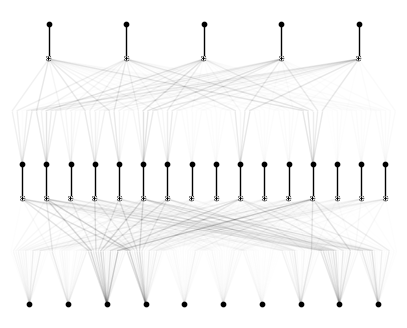

In [41]:
model1.kan.plot()

In [42]:
model1.kan.feature_score

tensor([0.1365, 0.1216, 0.4597, 0.3354, 0.0800, 0.0843, 0.0577, 0.1569, 0.3235,
        0.1894], device='cuda:0', grad_fn=<MeanBackward1>)